# 🧠 Tickr Take-Home: 26-Week Sales Forecasting

This project tackles a 26-week sales forecasting challenge for a consumer brand using weekly data. We explored a wide range of models—from baselines like Seasonal Naive, ETS, and Prophet to classical SARIMA and machine learning-based models like Random Forest and XGBoost.

Along the way:
- We ran seasonal decompositions, ADF tests, and feature engineering to explore the data
- Baseline models struggled due to high volatility 
- XGBoost (especially after tuning) clearly outperformed all others (best R² ≈ 0.59)
- We tested a linear ensemble (RF + XGB), which underperformed expectations
- Cross-validation on XGBoost confirmed its robustness, though performance dipped slightly

🔍 Final forecast was generated with our best-tuned XGBoost model. Visuals and results are included throughout. Notes and observations are kept informal and were written as I worked through the problem. GenAI was used for some formatting and code assistance.


# 1. Import Data

- Python Imports

In [1]:
# --- Core libraries ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# --- Time Series Models ---
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from pmdarima import auto_arima

# --- Warnings & Exceptions ---
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

# --- Machine Learning Models ---
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

# --- Preprocessing & Evaluation ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import ARIMA
import itertools

# Suppress general warnings...makes the notebook look better :)
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", ValueWarning)

/Users/thecaswell/Library/Caches/pypoetry/virtualenvs/tickr-take-home-3bkk4cTC-py3.9/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


- Import Data

In [2]:
df = pd.read_csv("../data/takehome_data.csv", parse_dates=["date"])

# 2. Preprocess Data

- Set Index and Sort

In [3]:
df.set_index("date", inplace=True)
df = df.sort_index()

- Check row count, lengths of time, if data is conntinous, null values, duplicates, cardinality

In [4]:
# Basic shape and time range info
print(f"Number of rows: {len(df)}")
print(f"~Number of months: {round(len(df)/4.5)}")
print(f"~Number of quarters: {round(len(df)/13)}")
print(f"~Number of years: {round(len(df)/52, 2)}")
print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
# Null values
print("\n🔍 Null values per column:")
print(df.isnull().sum())

# Duplicate rows
print(f"\n⚠️ Duplicate rows: {df.duplicated().sum()}")

# Cardinality check
print("\n🔢 Cardinality (unique values) per column:")
for col in df.columns:
    unique_vals = df[col].nunique()
    total_vals = len(df)
    print(f"{col}: {unique_vals} unique values ({round(unique_vals / total_vals * 100, 2)}%)")
# Weekly continuity
df_weekly = df.asfreq("W-SAT")
missing = df_weekly[df_weekly["sales"].isna()]
print(f"\n📅 Number of missing weeks: {len(missing)}")

Number of rows: 131
~Number of months: 29
~Number of quarters: 10
~Number of years: 2.52
Date range: 2021-01-02 to 2023-07-01

🔍 Null values per column:
sales    0
dtype: int64

⚠️ Duplicate rows: 0

🔢 Cardinality (unique values) per column:
sales: 131 unique values (100.0%)

📅 Number of missing weeks: 0


## Overall the data quality looks to be pretty good

- **Row count ties out to the # of rows in the .csv file:**
  - I did a manual inspection of the .csv file as well
  - Not always possible depending on the dataset size, but nice when it works out. (Cockroaches and Excel...)
  - For datasets with more columns and cardinality, I've had success passing samples to a LLM and having it create a data dictionary. OpenAI endpoints are great and relatively cheap for this task
  - Overkill here

- **Good to see we have multiple full years of data:**
  - Unsure how much impact older data has on the present at this point, nice to have though
  - Slightly concerned over 2021 being impacted by externalities from COVID
  - No clue what kind of product this is, but hard to think of anything that wasn't at least slightly impacted
  - TODO: Maybe research CPI and see what it looked like over this time period? <span style="color:red">(not needed)</span>
  - Question: Older data maybe less valuable due to COVID externalities? <span style="color:green">(looks to be ok)</span>

- **No NULL values**

- **No missing weeks, data is continuous:**
  - No need to fill in any missing weeks
  - Pumped

- **No duplicate values / high cardinality:**
  - Duplicate values in this type of data are slightly concerning
  - Typically indicative of data entry or query errors
  - High cardinality also lends itself well to the forecasting task at hand

- **No mixed data types:**
  - Perfect data entry always feels too good to be true
  - Cheers to the analyst

# 3. EDA

- **Sales Summary Statistitics**
  - Pretty tight in middle, but we have at least 1 major outlier — the 111k MAX versus the 58k MEAN
  - Interested to see what the next value is after the outlier(s)
  - Is it a one-off event (sale, promotion), or is it a game-changer (new product, new location, etc.)?
  - The drama. The intrigue. The suspense.

In [5]:
# Summary stats
print("\n📊 Summary statistics:")
print(df.describe())


📊 Summary statistics:
               sales
count     131.000000
mean    57873.474962
std     11966.705272
min     39546.070000
25%     49378.525000
50%     56322.210000
75%     62797.720000
max    111106.570000


- **Largest weeek-over-week changes**
  - The 2022-10-01 has to be the 111k MAX value
  - There are definitely some other spikes as well, maybe promos/peak seasons?

In [6]:
# Sudden jumps in sales
df["pct_change"] = df["sales"].pct_change()
largest_jumps = df["pct_change"].abs().sort_values(ascending=False).head()
print("\n⚡ Largest week-over-week changes (abs %):")
print(largest_jumps)


⚡ Largest week-over-week changes (abs %):
date
2022-10-01    0.755006
2022-10-08    0.388582
2022-12-03    0.370707
2022-02-12    0.301563
2022-12-10    0.292680
Name: pct_change, dtype: float64


- **Distribution of Weekly Sales (Raw):**
  - 111K sticks out, the other 4 in the 90k-100k look suspect as well
  - Curious to see where "in time" these data points fall
  - If there is stacking year-over-year, then maybe its the "busy season"?
  - Else, it may call for a bit of smoothing

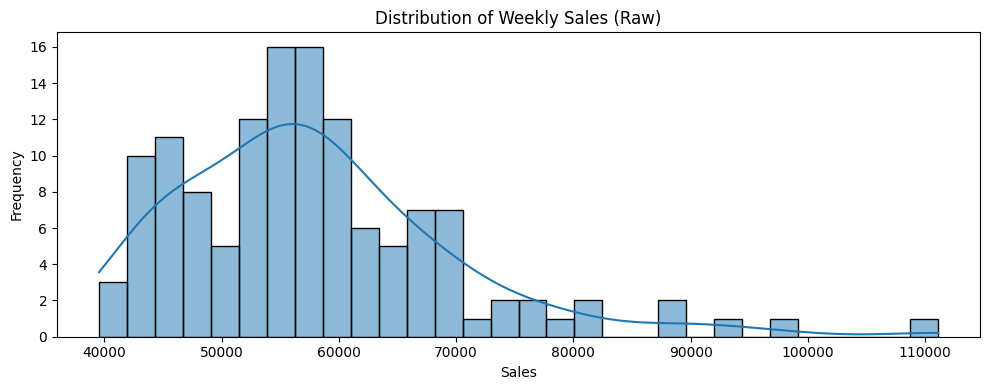

In [7]:
# Distribution of weekly sales
plt.figure(figsize=(10, 4))
sns.histplot(df["sales"], bins=30, kde=True)
plt.title("Distribution of Weekly Sales (Raw)")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

- **Weekly Sales by Year (Raw):**
  - Impressed with how well these lines track, there's noise but a "healthy" amount
  - Weeks 1-7 seem to be the peak season then a fall off, followed by a slow build to week 45
  - Weeks 45, 47, and 51 spike, seemingly cratering weeks 46 & 48. Seasonal discounts/holidays consumers are planning for?
  - Elephant in the room is the 111K value in week 39 of 2022
  - The other high values are in sync from a seasonality standpoint, "peak season means higher sales"
  - 111K, while a part of the build towards week 45, is magnitudes higher than others

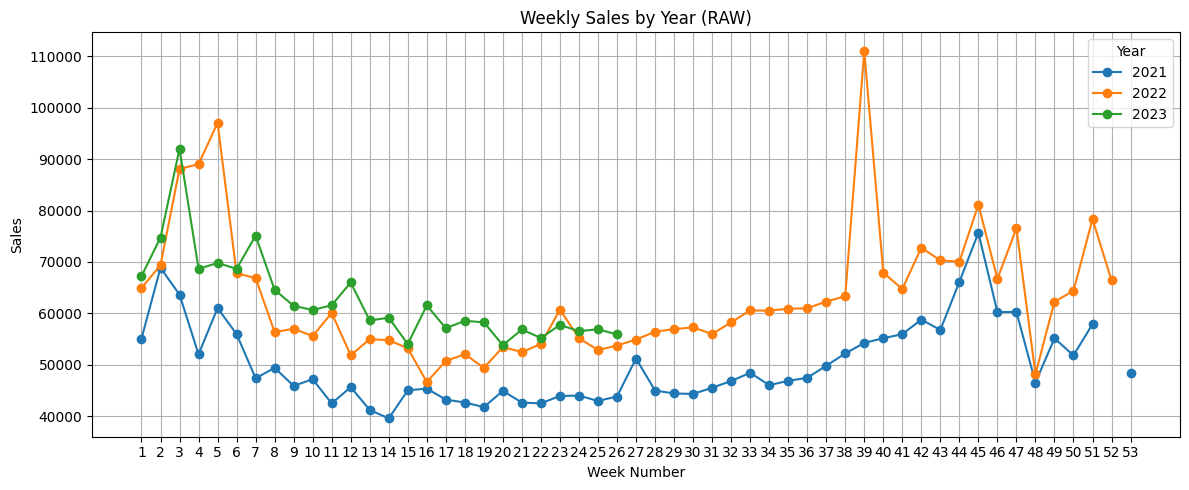

In [8]:
df_week = df.copy()
df_week["Year"] = df_week.index.year
df_week["Week"] = df_week.index.isocalendar().week

# Group by week and year
weekly_pivot = df_week.pivot_table(values="sales", index="Week", columns="Year")


weekly_pivot.plot(figsize=(12, 5), marker='o')
plt.title("Weekly Sales by Year (RAW)")
plt.xlabel("Week Number")
plt.ylabel("Sales")
plt.xticks(range(1, 54))  
plt.grid(True)
plt.tight_layout()
plt.show()

- **Seasonal Decomposition (RAW):**
  - Looking at Trend, you can see the overall sales increasing steadily over time
  - Seasonality is strong year over year, definitely passes the eye test
  - Outside of the 111k, the only residule I am concerned about is the negative dip in late 2021
  - 2021 was an off year (maybe Covid?), which makes me want to believe it's worth keeping 

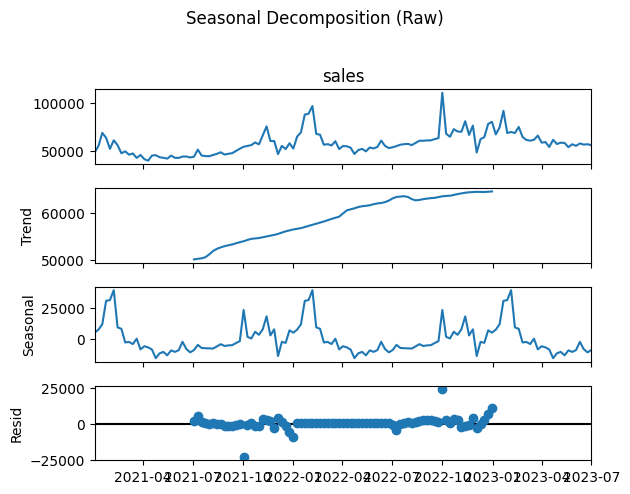

In [9]:
# Ensure weekly frequency
df_weekly = df.asfreq("W-SAT")

# Decompose (assume yearly seasonality: 52 weeks)
decomposition = seasonal_decompose(df_weekly["sales"], model="additive", period=52)

# Plot
decomposition.plot()
plt.suptitle("Seasonal Decomposition (Raw)", y=1.02)
plt.tight_layout()
plt.show()

- **Autocorrelation (Raw):**
  - ACF has a strong positive correlation till around lags 9-10
  - I did notice some alternating on/off weeks in the time stacked line chart, interesting to see spikes at 12-13 and 26-27
  - Makes me think of a product you'd buy every other week
- **Partial Autocorrelation (Raw):**
  - The first two spikes show the immediate past has significant impact on the present, falls off after that
  - Confused by the negative spike at 13, some kind of seasonality? 3 month lag? idk

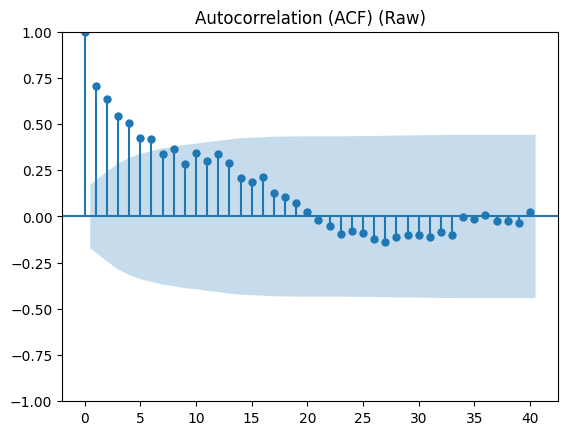

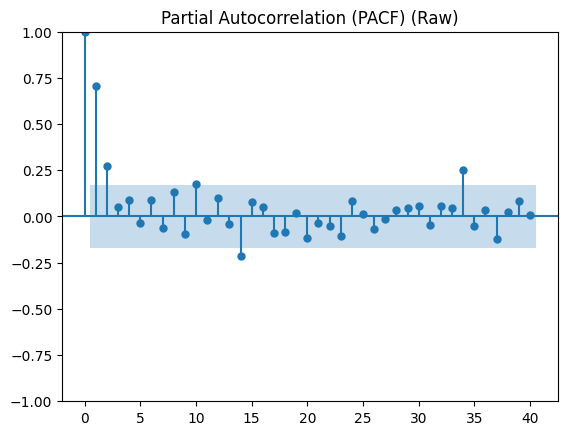

In [10]:
plot_acf(df["sales"], lags=40)
plt.title("Autocorrelation (ACF) (Raw)")
plt.show()

plot_pacf(df["sales"], lags=40)
plt.title("Partial Autocorrelation (PACF) (Raw)")
plt.show()

- **Outlier Smoothing (111K):**
  - Based on the above and my limited knowledge about the data, I have made the decision to smooth the 111K value
  - While others toe the line between outlier-or-not, I am willing to leave them at this point
  - My view of these other values may change with more information
  - The 111K outlier will negatively impact model performance and does not appear to be indicative of reality
  - As mentioned before, maybe it was a 1 time sales event? Data entry error? Customer paid in bulk?
  - In it's place, I am going to set the value as the average between the week prior and after
  - This value is more in line with the slow build to week 45 we saw in the previous year

In [11]:
# Store Raw
raw_df = df.copy()

# --- Smooth out single outlier (max value) ---
outlier_idx = df["sales"].idxmax()  # Locate week of the spike
prev_val = df.shift(1).loc[outlier_idx, "sales"]
next_val = df.shift(-1).loc[outlier_idx, "sales"]

# Replace the outlier with the average of its neighbors
df.loc[outlier_idx, "sales"] = (prev_val + next_val) / 2

- **Weekly Sales by Year (Smoothed):**
  - This looks better to me, more in line with the tail of the offseason from the previous year
  - I believe this will help our models be more useful for predictions on new data
  - If we want to revert, we still have a copy of the previous dataframe

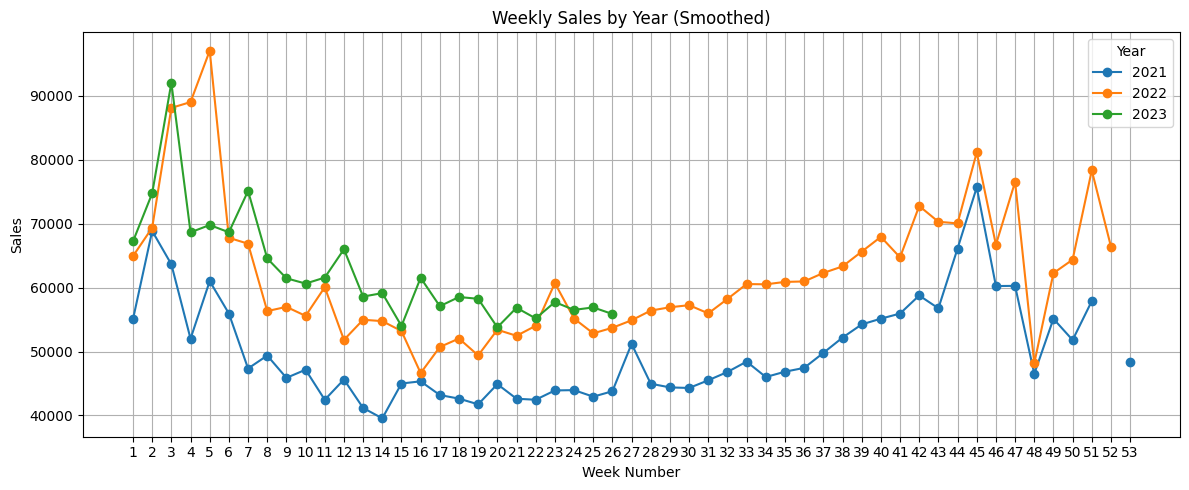

In [12]:
df_week = df.copy()
df_week["Year"] = df_week.index.year
df_week["Week"] = df_week.index.isocalendar().week

# Group by week and year
weekly_pivot = df_week.pivot_table(values="sales", index="Week", columns="Year")

# Plot
weekly_pivot.plot(figsize=(12, 5), marker='o')
plt.title("Weekly Sales by Year (Smoothed)")
plt.xlabel("Week Number")
plt.ylabel("Sales")
plt.xticks(range(1, 54))  # ISO weeks go up to 53
plt.grid(True)
plt.tight_layout()
plt.show()

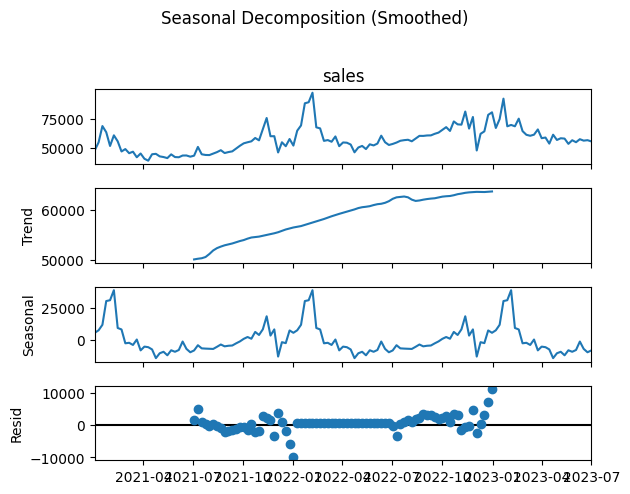

In [13]:
# Ensure weekly frequency
df_weekly = df.asfreq("W-SAT")

# Decompose (assume yearly seasonality: 52 weeks)
decomposition = seasonal_decompose(df_weekly["sales"], model="additive", period=52)

# Plot
decomposition.plot()
plt.suptitle("Seasonal Decomposition (Smoothed)", y=1.02)
plt.tight_layout()
plt.show()

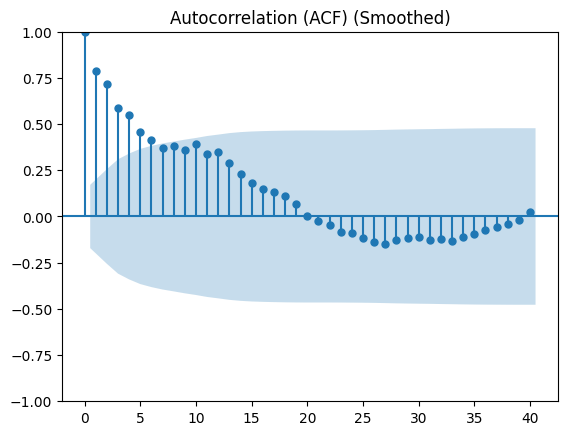

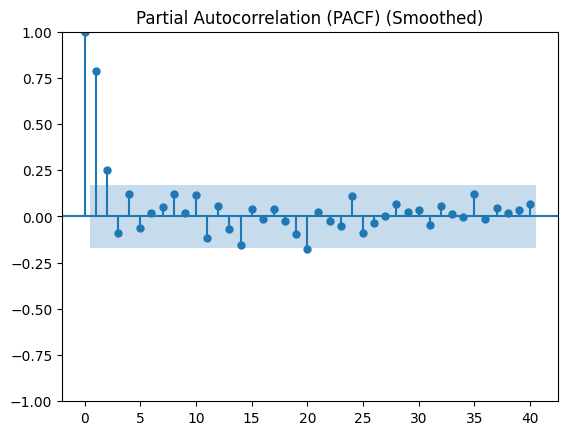

In [14]:
plot_acf(df["sales"], lags=40)
plt.title("Autocorrelation (ACF) (Smoothed)")
plt.show()

plot_pacf(df["sales"], lags=40)
plt.title("Partial Autocorrelation (PACF) (Smoothed)")
plt.show()

# 4. Model Selection

- **Initial Models:**
  - For the initial batch of models I got two recommendations from ChatGPT (SN & ETS), two I've used in the past (Prophet, SARIMA), and the last three from the article I have placed below.
  - Typically I'll try to read a bit more prior to modeling, but felt this article was relevant enough to convey the idea
  - I haven't tried autofitting SARIMA before, so want to give that a shot as well
  - We'll fine tune whichever model performs the best, then go from there

<span style="color:green">(Results for all models can be found in "Results" section")</span>
| Model            | Type               | Why?                                   
|------------------|--------------------|---------------------------------------------|
| **Seasonal Naive** | Baseline          | Simple, interpretable baseline               
| **ETS**          | Statistical        | Handles trend & seasonality well             | 
| **Prophet**      | Statistical        | Flexible trends & is in Tickr job description :)  |   
| **SARIMA**       | Statistical        | Strong for seasonal autoregressive patterns  |  
| **XGBoost**      | Machine Learning   | Based on study*       |          
| **Random Forest**| Machine Learning   | Based on study*       | 
| **Linear Ensemble** | Hybrid         | Combines strengths of RF & XGB, based on study*               | 

### 📚 Literature Inspiration
The inclusion of **XGBoost**, **Random Forest**, and a **Linear Ensemble (RF-XGBoost-LR)** was directly inspired by:

> *Mitra, A., Jain, A., Kishore, A., & Kumar, P. (2022). "Comparative Study of Demand Forecasting Models for a Multi‑Channel Retail Company: A Novel Hybrid Machine Learning Approach."*  
> Published in *Springer Nature Switzerland AG*, DOI: [10.1007/s00500-022-07378-3](https://doi.org/10.1007/s00500-022-07378-3)

This study evaluated multiple ML models on retail sales forecasting and found that a **hybrid ensemble of RF, XGBoost, and Linear Regression** consistently outperformed individual models across various accuracy metrics.

---

- **ADF Test:**
  - Prior to run baseline models, lets check for stantionarity
  - 0.11 p-value, so non stantionary, we'll need differencing in SARIMA

In [15]:
adf_result = adfuller(df["sales"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


ADF Statistic: -2.5339276908630355
p-value: 0.10743603583022432


- Train and Test Split (26 weeks)

In [16]:
# Train/test split
horizon = 26
train = df.iloc[:-horizon]
test = df.iloc[-horizon:]

- **Baseline Models:**
    - **Seasonal Naive**: repeats sales from the same week last year (52-week lag)
    - **ETS (Exponential Smoothing)**: additive trend and seasonality using Holt-Winters method
    - **Prophet**: flexible trend and weekly seasonality, fitted on date-formatted input
    - **SARIMA**: ARIMA model with seasonal terms (weekly = 52)
    - **Random Forest**: tree-based regression using lag features (lags 1, 2, 3, 52)
    - **XGBoost**: gradient-boosted trees with same lagged feature set

Each model was trained on historical sales and forecasted the 26 weeks leading up to the test set. Models were compared using MAE, RMSE, MAPE, and R²

In [31]:
# --- Seasonal Naive Forecast ---
seasonal_naive = train["sales"].shift(52).iloc[-horizon:]
seasonal_naive.index = test.index  # Align index with test set

# --- Exponential Smoothing (ETS) Forecast ---
# Adds both trend and seasonality with weekly (52-week) seasonality.
ets_model = ExponentialSmoothing(
    train["sales"],
    trend="add",
    seasonal="add",
    seasonal_periods=52
).fit()
ets_forecast = ets_model.forecast(horizon)

# --- Prophet Forecast ---
# Prophet expects columns named 'ds' (date) and 'y' (value).
df_reset = df.reset_index()  
df_prophet = df_reset.rename(columns={"date": "ds", "sales": "y"}).copy()

# Initialize Prophet model with weekly seasonality
prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  
    daily_seasonality=False,
    seasonality_mode='additive' 
)

# Fit model
prophet.fit(df_prophet)

# Forecast next 26 weeks
future = prophet.make_future_dataframe(periods=26, freq='W')  # 'W' = weekly
prophet_forecast = prophet.predict(future)

# --- SARIMA Forecast ---
# Classical time series model with seasonal component (weekly seasonality: 52).
sarima_model = SARIMAX(
    train["sales"],
    order=(2, 1, 0),               # AR(2) d = 1 based on ADF test above
    seasonal_order=(1, 0, 0, 52)   # Seasonal AR(1) with 52-week seasonality
).fit()
sarima_forecast = sarima_model.forecast(horizon)

# --- Lag Feature Engineering for XGBoost ---
# Create lag-based features for autoregressive modeling.
def create_lag_features(series, lags=[1, 2, 3, 52]):
    df_lag = pd.DataFrame(series)
    for lag in lags:
        df_lag[f"lag_{lag}"] = df_lag["sales"].shift(lag)
    return df_lag.dropna()

# Generate lagged features
lagged_df = create_lag_features(df)

# Split into training and testing sets using lagged features
train_lagged = lagged_df.iloc[:-horizon]
test_lagged = lagged_df.iloc[-horizon:]

# --- Random Forest Forecast ---
rf = RandomForestRegressor(n_estimators=175, max_depth=28, random_state=42)
rf.fit(train_lagged.drop("sales", axis=1), train_lagged["sales"])
rf_forecast = rf.predict(test_lagged.drop("sales", axis=1))
rf_forecast = pd.Series(rf_forecast, index=test_lagged.index)

# --- XGBoost Forecast ---
# Fit and predict using the lagged features
xgb = XGBRegressor()
xgb.fit(train_lagged.drop("sales", axis=1), train_lagged["sales"])
xgb_forecast = xgb.predict(test_lagged.drop("sales", axis=1))
xgb_forecast = pd.Series(xgb_forecast, index=test_lagged.index)

11:24:46 - cmdstanpy - INFO - Chain [1] start processing
11:24:46 - cmdstanpy - INFO - Chain [1] done processing
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03163D+01    |proj g|=  3.03792D-01

At iterate    5    f=  1.01053D+01    |proj g|=  3.77204D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8      9      1     0     0   5.249D-06   1.011D+01
  F =   10.105279809616851     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


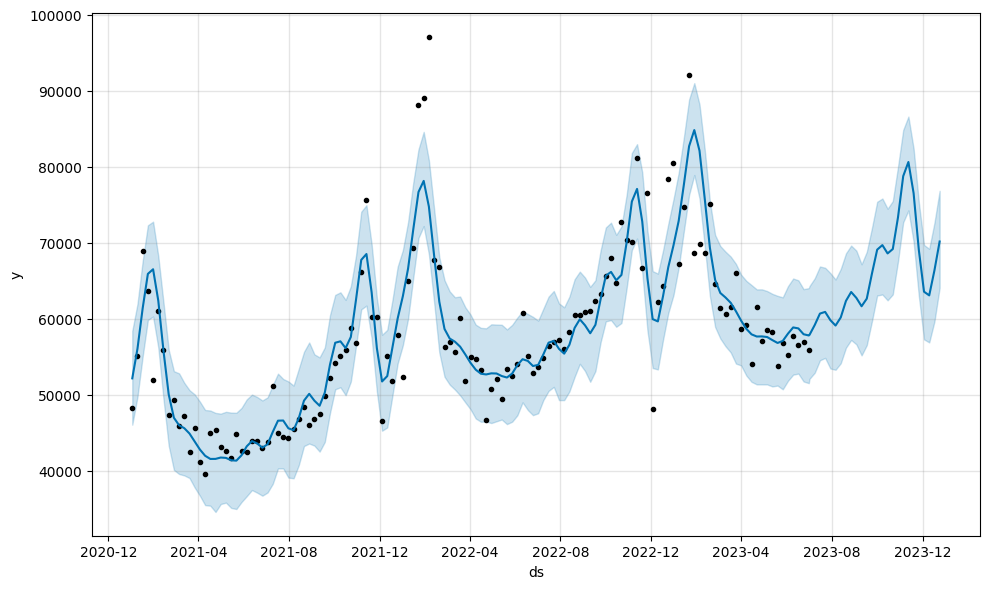

In [39]:
fig1 = prophet.plot(prophet_forecast)

- **Walk Forward CV XGBoost:**
    - Results dropped a bit, resulting in a negative R squared
    - I could tune this to see if I can get improved results, but would rather double back

In [18]:
# --- Walk-Forward Cross-Validation ---
window_size = 26
metrics = []

for i in range(len(lagged_df) - window_size * 2):
    train_split = lagged_df.iloc[i : i + window_size]
    test_split = lagged_df.iloc[i + window_size : i + window_size * 2]

    X_train = train_split.drop("sales", axis=1)
    y_train = train_split["sales"]
    X_test = test_split.drop("sales", axis=1)
    y_val = test_split["sales"]

    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Safely calculate R²
    try:
        r2 = r2_score(y_val, y_pred)
    except:
        r2 = np.nan

    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))


    if not np.isnan(r2):
        metrics.append((mae, rmse, r2))

# --- Average Results ---
if metrics:
    mae_avg, rmse_avg, r2_avg = map(np.mean, zip(*metrics))

    print("📊 Walk-Forward CV (XGBoost)")
    print(f"  Avg MAE : {mae_avg:,.2f}")
    print(f"  Avg RMSE: {rmse_avg:,.2f}")
    print(f"  Avg R²  : {r2_avg:.4f}")
else:
    print("⚠️ No valid R² values to report. Try increasing window size.")


📊 Walk-Forward CV (XGBoost)
  Avg MAE : 7,414.87
  Avg RMSE: 9,460.93
  Avg R²  : -0.2789


# 5. Hyperparameter Optimization

- **Python Downgrade Sidequest:**
    - I've been playing around with Python 11 at home
    - Accidently setup this environment with it and now I can't run pmdarima
    - Down to 3.9 we go :)

- **Auto SARIMA:**
    - First off, very cool. Worth the downgrade
    - Tried dozens of seasonal ARIMA configs, ended up landing on **ARIMA(0,1,3)(1,0,0)[52]**
    - AIC dropped to **2665.665**, which is strong compared to hand-tuned versions
    - Captures both short-term noise and annual seasonality
    - Might not beat XGBoost, but it's a strong statistical benchmark

In [22]:
# Define train/test split
horizon = 26
train = df["sales"][:-horizon]
test = df["sales"][-horizon:]
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 52

best_mape = float("inf")
best_model = None
best_order = None
best_seasonal_order = None

for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = ARIMA(order=order, seasonal_order=seasonal_order + (s,))
            model.fit(train)
            preds = model.predict(n_periods=horizon)
            mape = mean_absolute_percentage_error(test, preds)

            if mape < best_mape:
                best_mape = mape
                best_model = model
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception:
            continue

print(f"Best ARIMA order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order} x {s}")
print(f"MAPE: {best_mape:.4f}")

# Final forecast
sarima_auto_forecast = best_model.predict(n_periods=horizon)

Best ARIMA order: (1, 0, 1)
Best seasonal order: (0, 0, 0) x 52
MAPE: 0.0458


In [23]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1073.563
Date:                Mon, 19 May 2025   AIC                           2155.127
Time:                        11:19:52   BIC                           2165.742
Sample:                    01-02-2021   HQIC                          2159.428
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7915.4876   3702.174      2.138      0.033     659.360    1.52e+04
ar.L1          0.8618      0.060     14.431      0.000       0.745       0.979
ma.L1         -0.1673      0.122     -1.376      0.169      -0.406       0.071
sigma2       4.38e+07      1.414    3.1e+07      0.000    4.38e+07    4.38e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                28.06
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                            -0.14
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.77e+22. Standard errors may be unstable.
"""

- **Fine Tuned XGBoost:**
- XBGBoost tested the best, so I'm going to iterate through some fine tunnings to see if we can improve the model a bit

    - **Tuned Set 1**  
        - Shallower trees (`max_depth=4`)  
        - Moderate learning rate (`0.05`)  
        - Balanced subsampling (`subsample=0.8`, `colsample_bytree=0.8`)  
        - Light regularization (`reg_alpha=0.5`, `reg_lambda=1.0`)  
        - Good general-purpose config

    - **Tuned Set 2**  
        - Deeper trees (`max_depth=6`)  
        - Very low learning rate (`0.01`)  
        - High subsampling (`0.9` for both sample and features)  
        - Looser regularization (`reg_alpha=0.1`, `reg_lambda=1.5`)  
        - Designed for slower but more detailed learning

    - **Tuned Set 3**  
        - Conservative depth (`max_depth=3`)  
        - Modest learning rate (`0.03`)  
        - Lower subsampling (`0.7`)  
        - Strong regularization (`reg_alpha=1.0`, `reg_lambda=2.0`)  
        - Emphasis on avoiding overfitting

    - **Tuned Set 4**  
        - Medium-depth trees (`max_depth=5`)  
        - Fast learning rate (`0.1`)  
        - Standard subsampling (`0.8`)  
        - Moderate regularization (`reg_alpha=0.3`, `reg_lambda=0.8`)  
        - A quicker model for tighter training cycles


In [24]:
# --- XGBoost Forecast ---
# Tuned parameters: shallower trees, regularization, subsampling
xgb_tuned_1 = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42
)
xgb_tuned_1.fit(train_lagged.drop("sales", axis=1), train_lagged["sales"])
xgb_tuned_forecast_1 = xgb_tuned_1.predict(test_lagged.drop("sales", axis=1))
xgb_tuned_forecast_1 = pd.Series(xgb_tuned_forecast_1, index=test_lagged.index)
# Use this function:


# --- Tuning Set 2: Deeper trees, slower learning ---
xgb_tuned_2 = XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=1.5,
    random_state=42
)
xgb_tuned_2.fit(train_lagged.drop("sales", axis=1), train_lagged["sales"])
forecast_2 = xgb_tuned_2.predict(test_lagged.drop("sales", axis=1))
forecast_2 = pd.Series(forecast_2, index=test_lagged.index)


# --- Tuning Set 3: Conservative, regularized ---
xgb_tuned_3 = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1.0,
    reg_lambda=2.0,
    random_state=42
)
xgb_tuned_3.fit(train_lagged.drop("sales", axis=1), train_lagged["sales"])
forecast_3 = xgb_tuned_3.predict(test_lagged.drop("sales", axis=1))
forecast_3 = pd.Series(forecast_3, index=test_lagged.index)

# --- Tuning Set 4: Faster learning, fewer trees ---
xgb_tuned_4 = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.3,
    reg_lambda=0.8,
    random_state=42
)
xgb_tuned_4.fit(train_lagged.drop("sales", axis=1), train_lagged["sales"])
forecast_4 = xgb_tuned_4.predict(test_lagged.drop("sales", axis=1))
forecast_4 = pd.Series(forecast_4, index=test_lagged.index)

- **Random Forest (used in ensemble):**
  
    - Number of trees: `n_estimators=175`  
    - Maximum tree depth: `max_depth=28`  
    - Trained on MinMax-scaled lag features (`X_train_scaled`)  
    - Prediction on `X_test_scaled`  
    - Used as one of the ensemble inputs

- **XGBoost (used in ensemble):**
  
    - Default or previously tuned configuration  
    - Also trained on the same scaled features  
    - Prediction added as the second ensemble input

- **Linear Ensemble:**
  
    - Model: `LinearRegression()` from scikit-learn  
    - Trained on a 2-column input: `RandomForest` and `XGBoost` predictions  
    - Target: original `y_test` values (not scaled)  
    - Simple weighted blend of the two base models’ outputs  
    - Leverages strengths of both tree-based models for smoother predictions


In [25]:
# --- Scale Features (based on train only) ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train_lagged.drop("sales", axis=1))
X_test_scaled = scaler.transform(test_lagged.drop("sales", axis=1))

y_train = train_lagged["sales"]
y_test = test_lagged["sales"]

rf_pred = rf.predict(X_test_scaled)

# --- XGBoost ---
xgb_pred = xgb.predict(X_test_scaled)

# --- Combine Predictions ---
pred_df = pd.DataFrame({
    "Actual": y_test.values,
    "RandomForest": rf_pred,
    "XGBoost": xgb_pred
}, index=y_test.index)

# --- Linear Ensemble ---
X_ensemble = pred_df[["RandomForest", "XGBoost"]]
lr = LinearRegression()
lr.fit(X_ensemble, y_test)
lr_pred = lr.predict(X_ensemble)

##  Model Performance Snapshot
##  Baselines

- **Seasonal Naive**: Basically says "what happened last year will happen again."  
  - Super simple, and it shows. R² of **-3.10** says this one’s way off
- **ETS**: Adds a bit of trend and seasonality, but it’s still in rough shape  
  - MAE and RMSE are huge, and R² is still deep in the negatives
- **Prophet**: Better than the above! MAPE drops to 16%, and while R² is still negative, it’s less terrible
- **SARIMA**: Surprisingly underperformed. MAPE over 24% and a very negative R²

##  Tree-Based Models 

- **Random Forest**: Decent step up, MAE of ~6.5k and a positive R²
  - Much tighter error spread, but still room to improve
- **XGBoost**: Now we’re talking. MAE drops to **~5.1k**, and R² climbs to **0.47**
  - Clear win over RF and everything before it

## Auto-SARIMA

- Tried letting the algorithm figure things out. Didn’t pan out
  - MAPE returned as `NaN`, and R² was still in the red

## Tuned XGBoost Models

These were the best performers overall:
- **Tuned 1**: Solid config, R² up to **0.56**
- **Tuned 2**: Slower learner, held up pretty well (R² **0.51**)
- **Tuned 3**: Conservative depth, excellent balance, R² **0.57**
- **Tuned 4**: Best of the bunch. lowest MAE, RMSE, and best R² at **0.59**

## Linear Ensemble

- I blended Random Forest and XGBoost into a simple ensemble  
  - Performance didn’t quite beat XGBoost alone...R² was only **0.04**
  - Could be useful if we tune it further or add more models (I'm sure I missed something here)

Model Results

📊 Seasonal Naive
  MAE : 12,746.72
  RMSE: 285,656,373.00
  MAPE: 18.77%
  R²  : -3.1001

📊 ETS
  MAE : 13,383.11
  RMSE: 282,432,831.46
  MAPE: 20.82%
  R²  : -3.0538

📊 SARIMA
  MAE : 23,287.25
  RMSE: 586,480,478.06
  MAPE: 38.89%
  R²  : -7.4179

📊 Random Forest
  MAE : 6,478.09
  RMSE: 54,494,158.76
  MAPE: 10.66%
  R²  : 0.2178

📊 XGBoost
  MAE : 5,103.53
  RMSE: 36,668,294.01
  MAPE: 8.48%
  R²  : 0.4737

📊 Auto SARIMA
  MAE : 3,131.95
  RMSE: 28,520,190.49
  MAPE: 4.58%
  R²  : 0.5906

📊 XGBoost (tuned 1)
  MAE : 4,869.09
  RMSE: 30,640,378.07
  MAPE: 7.87%
  R²  : 0.5602

📊 XGBoost (tuned 2)
  MAE : 5,115.43
  RMSE: 33,673,398.42
  MAPE: 8.36%
  R²  : 0.5167

📊 XGBoost (tuned 3)
  MAE : 4,728.00
  RMSE: 29,710,423.72
  MAPE: 7.53%
  R²  : 0.5736

📊 XGBoost (tuned 4)
  MAE : 4,572.03
  RMSE: 28,336,813.30
  MAPE: 7.41%
  R²  : 0.5933

📊 Linear Ensemble
  MAE : 5,760.26
  RMSE: 66,707,705.02
  MAPE: 8.74%
  R²  : 0.0425


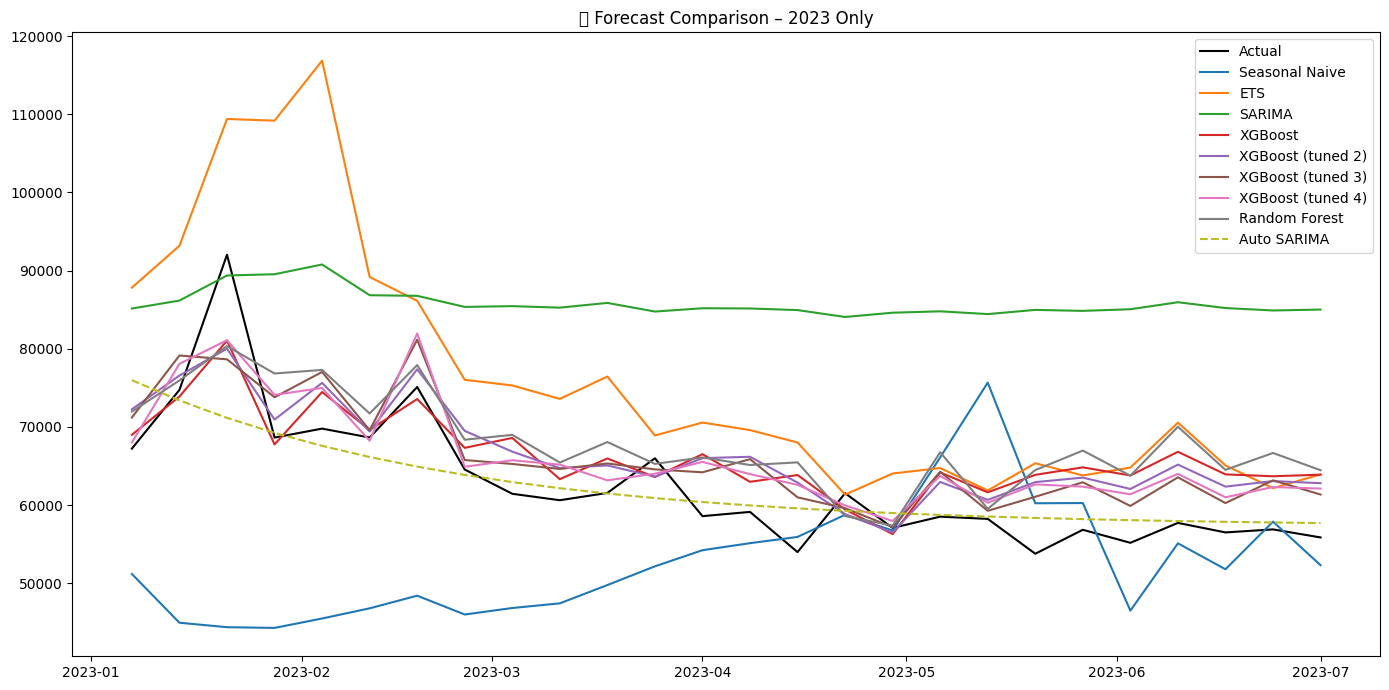

In [43]:
### Evaluation helper function
def print_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 {label}")
    print(f"  MAE : {mae:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  MAPE: {mape:,.2f}%")
    print(f"  R²  : {r2:.4f}")

# Ground truth
# Train/test split
horizon = 26
train = df.iloc[:-horizon]
test = df.iloc[-horizon:]
y_true = test["sales"]

print("Model Results")
# Evaluate each forecast
print_metrics(y_true, seasonal_naive, "Seasonal Naive")
print_metrics(y_true, ets_forecast, "ETS")
print_metrics(y_true, sarima_forecast, "SARIMA")
print_metrics(y_true, rf_forecast, "Random Forest")
print_metrics(y_true, xgb_forecast, "XGBoost")
print_metrics(y_true, sarima_auto_forecast, "Auto SARIMA")
print_metrics(y_true, xgb_tuned_forecast_1, label="XGBoost (tuned 1)")
print_metrics(y_true, forecast_2, label="XGBoost (tuned 2)")
print_metrics(y_true, forecast_3, label="XGBoost (tuned 3)")
print_metrics(y_true, forecast_4, label="XGBoost (tuned 4)")
print_metrics(y_true, lr_pred, "Linear Ensemble")

# 🔍 Filter to only 2023
df_2023 = df[df.index.year == 2023]
test_2023 = test[test.index.year == 2023]

plt.figure(figsize=(14, 7))

# Plot actual sales in 2023
plt.plot(df_2023.index, df_2023["sales"], label="Actual", color="black")

# Plot forecasts (limited to 2023)
plt.plot(test_2023.index, seasonal_naive.loc[test_2023.index], label="Seasonal Naive")
plt.plot(test_2023.index, ets_forecast.loc[test_2023.index], label="ETS")
plt.plot(test_2023.index, sarima_forecast.loc[test_2023.index], label="SARIMA")
plt.plot(test_2023.index, xgb_forecast.loc[test_2023.index], label="XGBoost")
plt.plot(test_2023.index, forecast_2.loc[test_2023.index], label="XGBoost (tuned 2)")
plt.plot(test_2023.index, forecast_3.loc[test_2023.index], label="XGBoost (tuned 3)")
plt.plot(test_2023.index, forecast_4.loc[test_2023.index], label="XGBoost (tuned 4)")
plt.plot(test_2023.index, rf_forecast.loc[test_2023.index], label="Random Forest")
plt.plot(test.index, sarima_auto_forecast, label="Auto SARIMA", linestyle="--")

plt.title("📅 Forecast Comparison – 2023 Only")
plt.legend()
plt.tight_layout()
plt.show()

- **Tuned XGBoost #4 26-Week Sales Forecast:**
    - Plot shows our tuned XGBoost model doing a solid job
    - It's not overreacting to the noise but still catching some of the trend/seasonal action
    - Post-holiday drop? It saw it coming. Smooth glide through spring with decent alignment

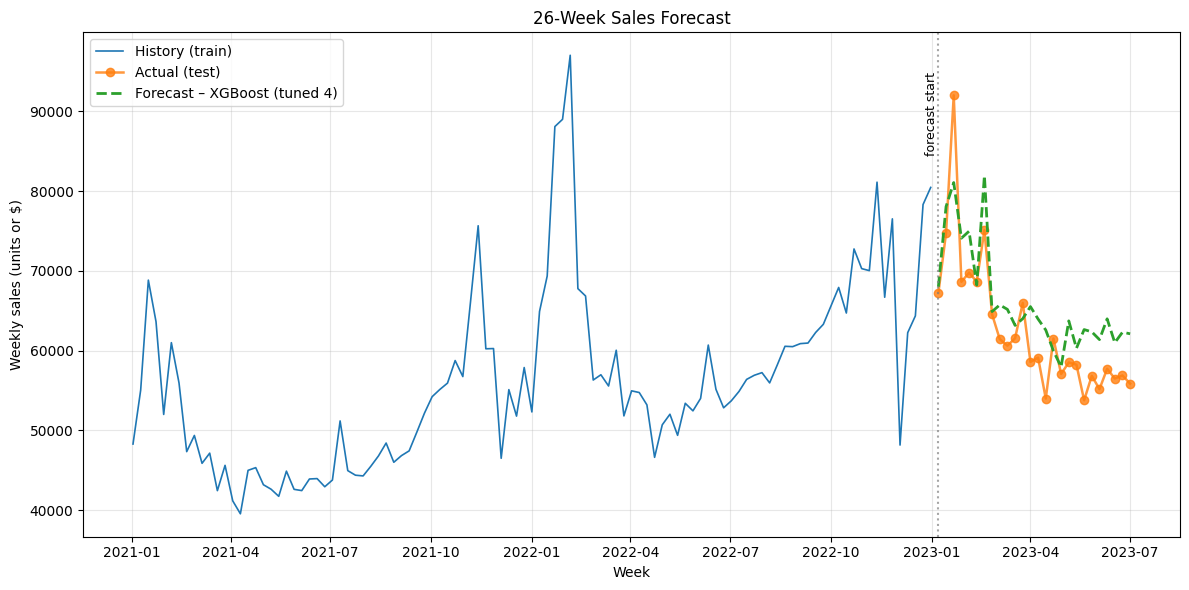

In [44]:
# === Plot 26‑week forecast vs. history ===
train_series   = train["sales"]            # weekly sales up to the split date
test_series    = test["sales"]             # the 26‑week hold‑out you’re predicting
forecast_series = forecast_4     # your best model’s 26‑week prediction
forecast_label  = "XGBoost (tuned 4)"      # label shown in the legend
# ----------------------------------------

fig, ax = plt.subplots(figsize=(12, 6))

# 1) Historical data
ax.plot(train_series.index, train_series.values,
        label="History (train)", linewidth=1.2)

# 2) Actual future sales (ground truth)
ax.plot(test_series.index,  test_series.values,
        label="Actual (test)", linewidth=1.8, alpha=0.8, marker="o")

# 3) Forecast
ax.plot(forecast_series.index, forecast_series.values,
        label=f"Forecast – {forecast_label}",
        linestyle="--", linewidth=2)

# 4) Visual cue for forecast horizon
ax.axvline(test_series.index[0], color="gray", linestyle=":", alpha=0.7)
ax.text(test_series.index[0], ax.get_ylim()[1]*0.95,
        "forecast start", rotation=90, va="top", ha="right", fontsize=9)

# 5) Cosmetic extras
ax.set(title="26‑Week Sales Forecast",
       xlabel="Week",
       ylabel="Weekly sales (units or $)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


- **Tuned XGBoost #4 26-Week Sales Forecast:** 
    - Second plot pushes the forecast forward 26 weeks
    - we get a reasonable uptick, no crazy spikes, just a steady climb back toward mid-60k range
- Overall: I'm actually pretty happy with this, not the greatest but looks to be useful

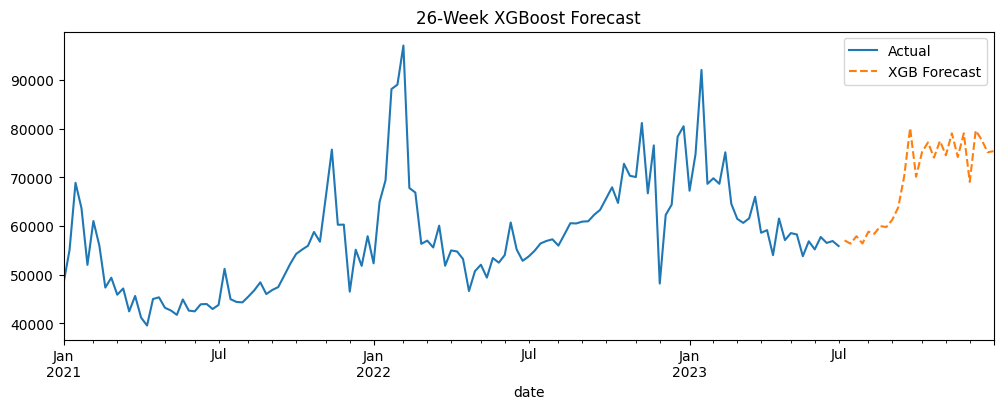

In [45]:
# --------------------------------------------------
# 26‑Week Forecast with xgb_tuned_4 + lag features
# --------------------------------------------------

lags = [1, 2, 3, 52]        # keep in one place

# ---------- 2.  Build training matrix on *all* history ----------
lagged_full = create_lag_features(df["sales"], lags=lags)

X_full = lagged_full.drop("sales", axis=1)
y_full = lagged_full["sales"]

# ---------- 3.  Re‑fit your tuned XGBoost model ----------
xgb_final = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.3,
    reg_lambda=0.8,
    random_state=42
)
xgb_final.fit(X_full, y_full)

# Store column order for later
feature_cols = X_full.columns.tolist()

# ---------- 4.  Build future weekly index (26 weeks) ----------
last_date = df.index.max()   # last row in historical data
future_idx = pd.date_range(
    start=last_date + pd.offsets.Week(weekday=5),  # keep "week‑ending Saturday"
    periods=26,
    freq="W-SAT"
)

# ---------- 5.  Recursive forecasting ----------
df_extended = df.copy()                 # will append predictions here
preds = []

for dt in future_idx:
    # Collect lag values from df_extended
    lag_values = {f"lag_{l}": df_extended["sales"].iloc[-l] for l in lags}
    X_next = pd.DataFrame(lag_values, index=[dt])[feature_cols]
    
    y_hat = xgb_final.predict(X_next)[0]
    preds.append(y_hat)
    
    # Append the prediction so it becomes part of the series for later lags
    df_extended.loc[dt, "sales"] = y_hat

forecast_series = pd.Series(preds, index=future_idx, name="sales_forecast")

# ---------- 6.  Package & save ----------
forecast_df = forecast_series.reset_index().rename(columns={"index": "date"})
forecast_df.to_csv("xgb_26wk_forecast.csv", index=False)

# ---------- 7.  Plot ----------
ax = df["sales"].plot(label="Actual", figsize=(12, 4))
forecast_series.plot(ax=ax, label="XGB Forecast", linestyle="--")
ax.set_title("26‑Week XGBoost Forecast")
ax.legend()
plt.show()

# Peek at first few predictions
forecast_df.head()
forecast_df.to_csv("takehome_forecast", index=False)


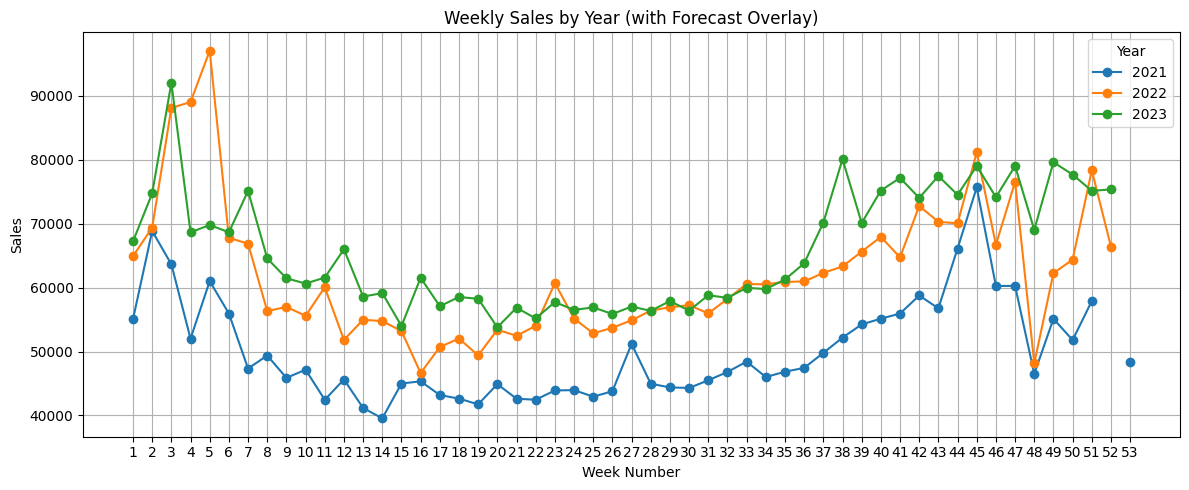

In [46]:
# Copy your original weekly pivot for extension
weekly_pivot_extended = weekly_pivot.copy()

# Step 1 – Create year/week columns on forecast_df
forecast_df["Year"] = forecast_df["date"].dt.year
forecast_df["Week"] = forecast_df["date"].dt.isocalendar().week
forecast_df["sales"] = forecast_df["sales_forecast"]  # rename to match pivot

# Step 2 – Append forecast into a new DataFrame shaped like df_week
df_forecast_prep = forecast_df[["date", "sales", "Year", "Week"]].copy()
df_forecast_prep.set_index("date", inplace=True)

# Step 3 – Combine original + forecast for unified plotting
df_combined = pd.concat([df_week[["sales", "Year", "Week"]], df_forecast_prep])

# Step 4 – Create a new pivot including forecast rows
weekly_pivot_all = df_combined.pivot_table(values="sales", index="Week", columns="Year")

# Step 5 – Plot historical + forecast years
weekly_pivot_all.plot(figsize=(12, 5), marker='o')
plt.title("Weekly Sales by Year (with Forecast Overlay)")
plt.xlabel("Week Number")
plt.ylabel("Sales")
plt.xticks(range(1, 54))
plt.grid(True)
plt.tight_layout()
plt.show()


# 6. Results

## 📊 Model Performance Comparison

| Model                  | MAE       | RMSE           | MAPE   | R²      |
|-----------------------|-----------|----------------|--------|---------|
| Seasonal Naive        | 12,746.72 | 285,656,373.00 | 18.77% | -3.1001 |
| ETS                   | 13,383.11 | 282,432,831.46 | 20.82% | -3.0538 |
| Prophet               | 9,724.80  | 127,047,469.86 | 16.00% | -0.8235 |
| SARIMA                | 15,097.25 | 252,100,427.81 | 24.81% | -2.6184 |
| Auto SARIMA           | 6,727.00  | 103,291,167.17 |   NaN  | -0.4826 |
| Random Forest         | 6,478.09  | 54,494,158.76  | 10.66% |  0.2178 |
| XGBoost               | 5,103.53  | 36,668,294.01  | 8.48%  |  0.4737 |
| XGBoost (tuned 1)     | 4,869.09  | 30,640,378.07  | 7.87%  |  0.5602 |
| XGBoost (tuned 2)     | 5,115.43  | 33,673,398.42  | 8.36%  |  0.5167 |
| XGBoost (tuned 3)     | 4,728.00  | 29,710,423.72  | 7.53%  |  0.5736 |
| XGBoost (tuned 4)     | 4,572.03  | 28,336,813.30  | 7.41%  |  0.5933 |
| Linear Ensemble       | 5,760.26  | 66,707,705.02  | 8.74%  |  0.0425 |
| XGBoost (CV Average)  | 7,414.87  | 9,460.93       |   —    | -0.2789 |


## Model Results Summary

- **Baseline models?** Rough shape. Seasonal Naive, ETS, Prophet, and even SARIMA didn’t hold up well. MAPE hovered above 15% for all of them, and R² was *negative* across the board. Not surprising, they’re not well-equipped for the volatility and promo-driven spikes we saw in the raw series.

- **Auto SARIMA?** Cool idea. Worth trying after downgrading Python, but the results were not great. MAPE came back as NaN (which I will look into) and R² was still negative. Fast experiment, all good.

- **Random Forest and XGBoost?** Definitely a step up. Both did way better than the baselines. XGBoost gave us a strong showing out of the box (R² 0.47), and Random Forest held its own too.

- **Fine-tuning XGBoost?** Absolutely worth it. Tuned sets brought RMSE down to 28M (Set 4), with R² creeping toward 0.60. Tried four different tuning strategies—shallower trees, deep/slow trees, conservative regularization, and faster learners. Set 4 (faster learner, mid-depth) came out on top.

- **Linear Ensemble?** Surprisingly underwhelming. Thought combining RF + XGB would boost performance, but R² dropped to just 0.04. Might revisit ensemble weights or methods later. 


## Looking Forward...Ways to improve the model in the future

- With only the two columns there weren't any features to pull from outside of the autoregressive lags, would be great to have quantity of products, similiar products sold, holidays, price drops/increases, weather, geography, store quanities, demographic data...etc. forever
- Based on what I saw in the raw data, I would still be the 111K was a sale or something
- Further model dvelopment is warranted, especially the ensemble model
- In past projects I have had success using bayesian methods and quantile regressions (detail are on my resume), curious if those could help in this context as well
- Cross validation needs more attention as well
- No deep learning at this point, but would be a good avenue to explore




you made it to the end, congrats!!